# XGBoost

In [2]:
import xgboost
from xgboost import plot_importance
from bgpredict.helpers import S3Connection
from dotenv import load_dotenv
import multiprocessing
import json
import os
import numpy as np
from numpy.random import default_rng
import pandas as pd
from dotenv import load_dotenv
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import sqlalchemy
from sqlalchemy import create_engine
from datetime import datetime
from skopt import BayesSearchCV, dump, load
from skopt.plots import plot_objective, plot_histogram
import matplotlib.pyplot as plt 

In [3]:
os.chdir('../')
load_dotenv()
os.chdir('./Baseline')

In [4]:
def clean_data(df):
    # Drop rows with no Y value
    df = df.dropna(subset='bg')

    # Fill nulls (lag BG values) with 0 to indicate data is unavailable
    print(f"Null values to be filled by column:")
    nulls = df.isna().sum()
    null_idx = list(nulls.index)
    vals = list(nulls)
    for col, val in list(zip(null_idx, vals)):
        if val > 0:
            print(col, val)
    df = df.fillna(0)

    # Sort by timestamp
    current_len = len(df)
    df = df.loc[~(df['timestamp_clean'].apply(type) == int), :]
    print(f"Dropping {current_len - len(df)} invalid timestamps")
    df = df.sort_values(by="timestamp_clean")

    # Set index to time_stamp_clean
    df.index = df['timestamp_clean']
    df = df.drop(labels=['timestamp_clean'], axis=1)

    # Drop first row by subject which has data quality issues
    df = df[df.groupby('subjectid').cumcount() > 0]

    # Drop columns that are indices, irrelevant, or capture in OHE variables
    drop_cols = ['timestamp', 'date', 'time']
    df = df.drop(labels=drop_cols, axis=1)

    # One hot Encode Weekdays
    weekdays = np.unique(df['weekday'])
    ohe_weekdays = [f"ohe_{day}" for day in weekdays]
    df[ohe_weekdays] = pd.get_dummies(df.weekday)
    df = df.drop(labels="weekday", axis=1)

    return df

In [5]:
start = datetime.now()
location = f"postgresql://postgres:{os.environ.get('db_password')}@{os.environ.get('db_location')}"
engine = create_engine(location)
conn = engine.connect()
raw_df = pd.read_sql("select * from public.tb_final_dataset", conn)
print(f'Load finished in {datetime.now()-start}')

Load finished in 0:07:54.283792


In [15]:
start= datetime.now()
clean_df = clean_data(raw_df)
print(f"Data cleaned in {datetime.now()-start}")

Null values to be filled by column:
timestamp 712
timestamp_clean 712
date 712
time 712
weekday 712
hour 712
minute 712
datediff_currentbg_lastbg_inseconds 831
bg_lag_1 41454
bg_lag_2 42102
bg_lag_3 42194
bg_lag_4 43018
bg_lag_5 43615
bg_lag_6 43754
bg_lag_7 44236
bg_lag_8 44525
bg_lag_9 44641
bg_lag_10 44952
bg_lag_11 45240
bg_lag_12 45407
Dropping 712 invalid timestamps
Data cleaned in 0:01:22.098429


In [16]:
rng = default_rng(46)
subjects = clean_df.groupby("subjectid")['entryid'].count().sort_values()
subjects = list(subjects.loc[subjects > 1000].index)
drop_subjects = rng.choice(subjects, 14)
drop_subjects

array([60844515, 41131654, 40997757, 94200862, 91161972, 28608066,
       76817975, 37875431, 63047517, 72492570, 80796147, 87770486,
       95851255, 70454270])

In [17]:
clean_df = clean_df.loc[~clean_df['subjectid'].isin(drop_subjects), :]

In [18]:
def create_cv_splits(df):
    df = df.reset_index()
    subjects = np.unique(df['subjectid'])
    print(len(subjects), "in subset" )
    cv_splits = []
    for subject in subjects:
        train_idx = np.array(df.loc[(df['subjectid']==subject) & (df['train_set']==1)].index)
        val_idx = np.array(df.loc[(df['subjectid']==subject) & (df['validation_set']==1)].index)
        if len(train_idx) < 5 or len(val_idx) < 5:
            print(f"Not enough rows for subject {subject}")
            continue 
        split = (train_idx, val_idx)
        cv_splits.append(split)
    return cv_splits

In [19]:
def train_test_cv_split(df):
    clean_df_reset = df.reset_index()
    
    train_X = clean_df_reset.loc[(clean_df_reset['train_set'] == 1) | (clean_df_reset['validation_set'] == 1) , clean_df_reset.columns != 'bg']
    train_y = clean_df_reset.loc[(clean_df_reset['train_set'] == 1) | (clean_df_reset['validation_set'] == 1), clean_df_reset.columns == 'bg']
    
    test_X = clean_df_reset.loc[(clean_df_reset['test_set'] == 1), clean_df_reset.columns != 'bg']
    test_y = clean_df_reset.loc[(clean_df_reset['test_set'] == 1), clean_df_reset.columns == 'bg']
    
    cv_splits = create_cv_splits(train_X)

    drop_cols = ['train_set', 'validation_set', 'test_set', 'subjectid', 'entryid', 'timestamp_clean']
    train_X = train_X.drop(labels=drop_cols, axis=1)
    test_X = test_X.drop(labels=drop_cols, axis=1)
    
    return train_X, train_y,test_X, test_y, cv_splits

In [20]:
train_X, train_y, test_X, test_y, cv_splits = train_test_cv_split(clean_df)

125 in subset
Not enough rows for subject 33470634


In [21]:
n_cpu = os.cpu_count()
print(f"Using {n_cpu} CPUs for {len(train_X)} rows")

start = datetime.now()
# params_test = {"n_estimators":range(50,400,40)}
params_test = {"max_depth": [i for i in range(2, 20, 2)],
               "learning_rate": [0.01, 0.1,0.2,0.3, 0.5, 0.75, 1],
               "n_estimators":[x for x in range(50,400,50)],
               "reg_alpha": [0,0.0001,0.001,0.01,0.1, 0.2, 0.3, 0.5, 0.75, 1, 2, 3],
               "reg_lambda":[0,0.0001,0.001,0.01,0.1, 0.2, 0.3, 0.5, 0.75, 1, 2, 3],
               "gamma": [0, 0.25, 0.5, 1.0, 2, 4, 8, 16],
               "min_child_weight": [0.25, 0.5, 1, 3, 5, 7],
               "colsample_bytree": [0.5 + i/10 for i in range(0, 6)],
               "colsample_bylevel": [0.5 + i/10 for i in range(0, 6)],
               "colsample_bynode": [0.5 + i/10 for i in range(0, 6)],
               "subsample": [0.5 + i/10 for i in range(0, 6)],
               "max_delta_step": [i for i in range(0,11)]
              }

regressor = xgboost.XGBRegressor(eval_metric="rmse", verbosity=0)

cv_search = BayesSearchCV(estimator=regressor,
                              search_spaces = params_test,
                              n_iter=200,
                              n_jobs=n_cpu, 
                              cv=cv_splits,
                              verbose=1)

cv_search.fit(train_X, train_y)
print(f'Finished in: {datetime.now()-start}')

print("val. score: %s" % cv_search.best_score_)
print("test score: %s" % cv_search.score(test_X, test_y))
print("best params: %s" % str(cv_search.best_params_))

Using 64 CPUs for 4169251 rows
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for ea

/home/ec2-user/.cache/pypoetry/virtualenvs/bgpredict-iduEK74V-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 1

/home/ec2-user/.cache/pypoetry/virtualenvs/bgpredict-iduEK74V-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 1

/home/ec2-user/.cache/pypoetry/virtualenvs/bgpredict-iduEK74V-py3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 124 fits
Fitting 124 folds for each of 1 candidates, totalling 1

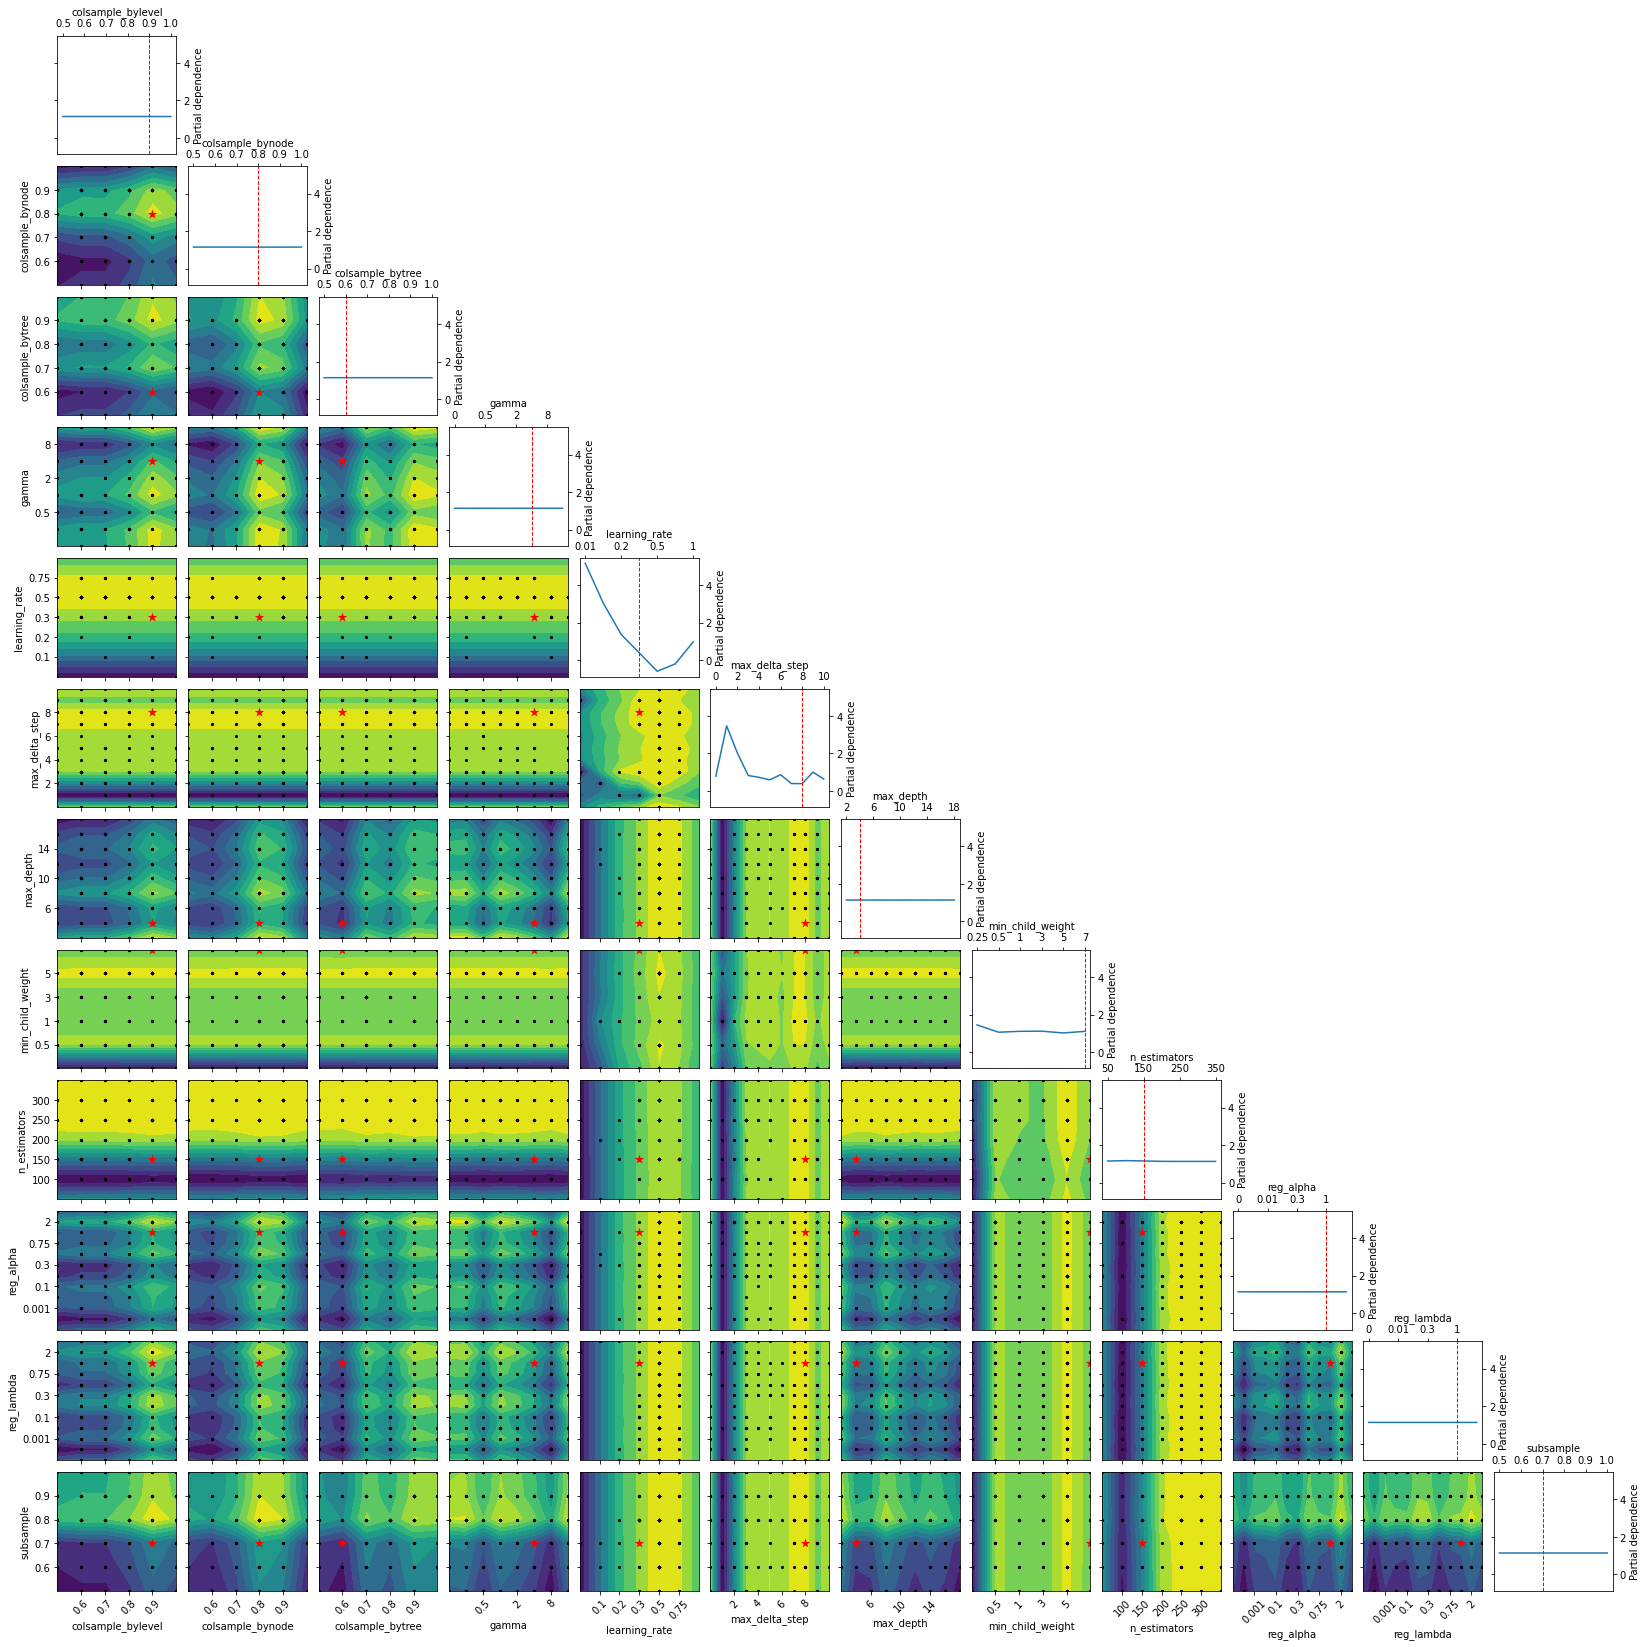

In [22]:
_ = plot_objective(cv_search.optimizer_results_[0])

In [23]:
best_estimator = cv_search.best_estimator_
best_estimator.save_model('./model.json')

In [24]:
model_name = f"{datetime.now().time()}_L{len(train_X)}".replace(":", ".")
location = f"models/xgboost/{model_name}"
location

'models/xgboost/11.21.42.393804_L4169251'

In [25]:
s3_conn = S3Connection()
bucket = s3_conn.bucket_name
with open('./model.json') as f:
    model = json.load(f)
    s3_conn.s3_client.put_object(Bucket=bucket, Key=location, Body=json.dumps(model))
os.remove("./model.json")

In [26]:
dump(cv_search, "./cv_search")
loaded = load('./cv_search')
s3_conn.s3_client.put_object(Bucket=bucket, Key=f"{location}CV_Search", Body=json.dumps(model))

{'ResponseMetadata': {'RequestId': 'A3BNBMB0TKE4HF1G',
  'HostId': 'cc9Tsrxr+xLHRYCBeKpSfbudr8Naqmuz1OX+j1DzgHBrN83+wZT9O0wRv2IX5Eg97c3WL6rBJT0=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'cc9Tsrxr+xLHRYCBeKpSfbudr8Naqmuz1OX+j1DzgHBrN83+wZT9O0wRv2IX5Eg97c3WL6rBJT0=',
   'x-amz-request-id': 'A3BNBMB0TKE4HF1G',
   'date': 'Wed, 27 Jul 2022 11:21:44 GMT',
   'x-amz-version-id': 'KV4vQEuDkogMAZU7QWnaFO5GDdryYCyG',
   'etag': '"636e950eb26cf66d2b840001027b39e2"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"636e950eb26cf66d2b840001027b39e2"',
 'VersionId': 'KV4vQEuDkogMAZU7QWnaFO5GDdryYCyG'}

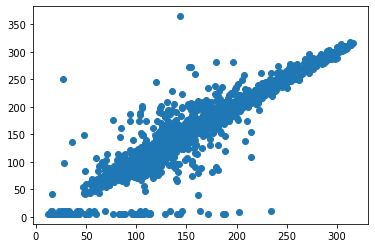

In [27]:
preds = best_estimator.predict(train_X)
plt.scatter(preds[:10000], train_y[:10000])

In [28]:
best_estimator.score(test_X, test_y)

0.9400102752400065

In [33]:
preds.sort()
preds

array([  5.5306053,   7.63463  ,   7.63463  , ..., 360.49948  ,
       360.49948  , 360.49948  ], dtype=float32)

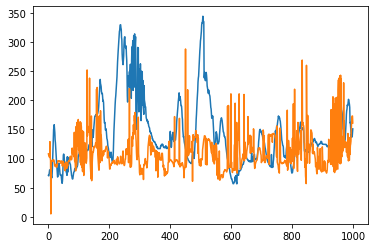

In [30]:
x_axis = [i for i in range(1000)]
plt.plot(x_axis, preds[12000:13000])
plt.plot(x_axis, test_y[12000:13000])